**COVID-19 CLASSIFICATION ON CHEST X_RAY IMAGES USING PRETRAINED VGG16 MODEL**

In [1]:
import os
import glob
import cv2 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from keras.models import load_model  
from sklearn.model_selection import train_test_split
from keras import optimizers
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten ,Input, Conv2D ,MaxPooling2D ,Dropout ,BatchNormalization ,GlobalMaxPool2D
from tensorflow.keras.models import Sequential , Model , load_model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from skimage.feature import greycomatrix, greycoprops
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
import matplotlib.image as mpimg
import pickle
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow import keras 
from tensorflow.keras import layers
from keras.models import Model
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [2]:
#HYPERPARAMETERS
num_epochs = 40
batch_size = 32
num_classes = 2
img_dim = 128
n_channel = 3
input_shape = (img_dim,img_dim,n_channel)
data_dir = '/content/drive/MyDrive/pdataset1/'

In [3]:
data_display = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                                shuffle=True, 
                                                                image_size = (128, 128),
                                                                batch_size = 32)

Found 13808 files belonging to 2 classes.


In [4]:
class_names = data_display.class_names

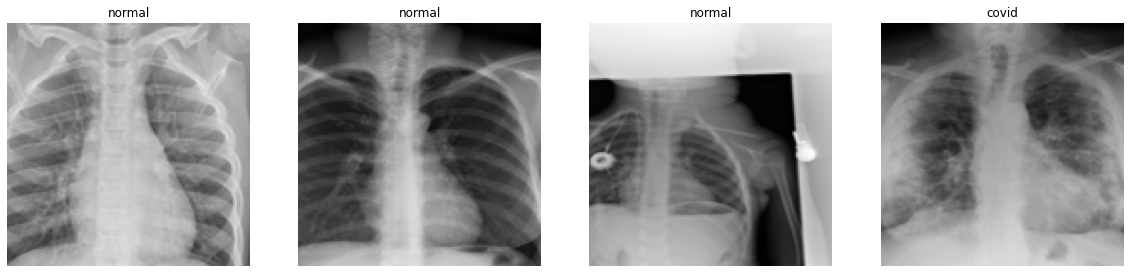

In [5]:
plt.figure(figsize=(20, 20))
for image_batch, labels_batch in data_display.take(1):
    for i in range(4):
        ax = plt.subplot(1, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [6]:
#Creating dataframe of (Image,Label) from the images
def createFrame(path,IMG_DIM):
    train_imgs = []
    labels = []
    #getting all folder name
    directories = os.listdir(path)
    for i in range(len(directories)):
        ls = []
        temp = []
        curPath = path +'/' +directories[i] + '/*'
        #getting all files name
        ls = glob.glob(curPath)
        for img in ls:
            x = img_to_array(load_img(img,target_size = IMG_DIM))
            temp.append(x)

        #print(len(ls))
        train_imgs  = train_imgs + temp
        label = []
        label = [i]*len(ls)
        labels += label

    df = pd.DataFrame(list(zip(train_imgs,labels)))
    df = df.sample(frac = 1) 
    return df

In [7]:
def data_split(df):
    df_imgs = df[0]
    df_imgs = list(df[0])
    df_imgs = np.array(df_imgs)
    df_imgs = df_imgs/255
    
    df_labels = df[1]
    df_labels = np.array(df[1])
    encoder = LabelEncoder()
    encoder.fit(df_labels)
    df_labels = encoder.transform(df_labels)
    df_labels = np_utils.to_categorical(df_labels)

    X_train, X_val, y_train, y_val = train_test_split(df_imgs, df_labels, test_size=0.2)

    return X_train, X_val, y_train, y_val


In [8]:
def Vgg16():
    
    print(" USING PRETRAINED VGG16 ON IMAGENET AS OUR MODEL")
    input_shape_vgg = input_shape
    vgg_model = keras.applications.VGG16(include_top=False,weights="imagenet",input_shape=input_shape_vgg)
    for layer in vgg_model.layers:
        layer.trainable = False
   
    ll = vgg_model.get_layer('block5_pool')
    lo = ll.output

    layer = keras.layers.Flatten()(lo)
    layer = keras.layers.Dense(units=512,activation='relu')(layer)
    layer = keras.layers.Dense(units=256,activation='relu')(layer)
    layer = keras.layers.Dropout(0.30)(layer)
    layer = keras.layers.Dense(units=64,activation='relu')(layer)
    layer = keras.layers.Dense(units=2,activation='sigmoid')(layer)
    
    model = keras.models.Model(vgg_model.input, outputs=layer)
    
    model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['acc'])
    print("--------------------------------MODEL COMPILED---------------------------------------")

    return model

In [9]:
model=Vgg16()

 USING PRETRAINED VGG16 ON IMAGENET AS OUR MODEL
58900480/58889256 [==============================] - 0s 0us/step
--------------------------------MODEL COMPILED---------------------------------------


In [10]:
df = createFrame(data_dir,input_shape)

In [11]:
df.head()

,0,1
12323,"[[[123.0, 123.0, 123.0], [130.0, 130.0, 130.0]...",1
9755,"[[[33.0, 33.0, 33.0], [37.0, 37.0, 37.0], [39....",0
1909,"[[[140.0, 140.0, 140.0], [145.0, 145.0, 145.0]...",0
651,"[[[4.0, 4.0, 4.0], [4.0, 4.0, 4.0], [3.0, 3.0,...",0
10163,"[[[133.0, 133.0, 133.0], [137.0, 137.0, 137.0]...",0


In [12]:
X_train, X_val, y_train, y_val = data_split(df)

In [13]:
print(f'X_train shape: {X_train.shape}')
print(f'X_train shape: {y_train.shape}')
print(f'X_train shape: {X_val.shape}')
print(f'X_train shape: {y_val.shape}')

X_train shape: (11046, 128, 128, 3)
X_train shape: (11046, 2)
X_train shape: (2762, 128, 128, 3)
X_train shape: (2762, 2)


In [14]:
check_pointing1 = ModelCheckpoint('covidCXR_model2/', save_best_only=True, monitor = 'val_loss')

In [15]:
history = model.fit(X_train, y_train, epochs=20, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[check_pointing1], verbose=1)

Epoch 1/20
346/346 [==============================] - 26s 46ms/step - loss: 0.3084 - acc: 0.8724 - val_loss: 0.2389 - val_acc: 0.9041
Epoch 2/20
346/346 [==============================] - 15s 43ms/step - loss: 0.2082 - acc: 0.9201 - val_loss: 0.1973 - val_acc: 0.9243
Epoch 3/20
346/346 [==============================] - 14s 42ms/step - loss: 0.1761 - acc: 0.9317 - val_loss: 0.1866 - val_acc: 0.9283
Epoch 4/20
346/346 [==============================] - 15s 42ms/step - loss: 0.1560 - acc: 0.9391 - val_loss: 0.1677 - val_acc: 0.9385
Epoch 5/20
346/346 [==============================] - 12s 36ms/step - loss: 0.1290 - acc: 0.9504 - val_loss: 0.2542 - val_acc: 0.8965
Epoch 6/20
346/346 [==============================] - 12s 36ms/step - loss: 0.1185 - acc: 0.9552 - val_loss: 0.1743 - val_acc: 0.9305
Epoch 7/20
346/346 [==============================] - 15s 42ms/step - loss: 0.1007 - acc: 0.9617 - val_loss: 0.1595 - val_acc: 0.9399
Epoch 8/20
346/346 [==============================] - 12s 36ms

In [19]:
from tensorflow.keras.models import load_model
model1 = load_model('covidCXR_model2/')

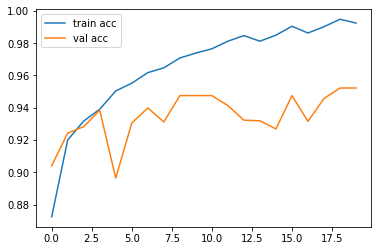

In [16]:
#Accuracy Plot
plt.plot(history.history['acc'], label='train acc')
plt.plot(history.history['val_acc'], label='val acc')
plt.legend()
plt.show()

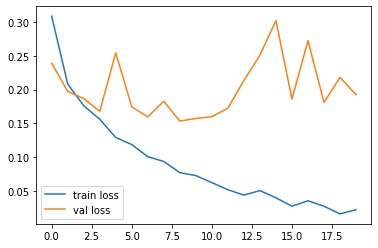

In [17]:
#Loss Plot
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [20]:
#Model Evaluation
model1.evaluate(X_val,y_val,batch_size=32)

87/87 [==============================] - 3s 28ms/step - loss: 0.1533 - acc: 0.9475


[0.15327516198158264, 0.9475018382072449]

In [21]:
#predict
y_pred=model1.predict(X_val)
y_pred=np.argmax(y_pred,axis=1)
actual_labels = np.argmax(y_val,axis=-1)

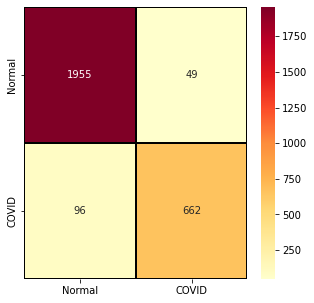

In [22]:
plt.rcParams.update({'font.size': 10})
cm = confusion_matrix(actual_labels, y_pred)
cm = pd.DataFrame(cm, index = ['0', '1'], columns = ['0', '1'])
cm
class_names = ['Normal','COVID']
def plot_confusion_matrix (cm):
    plt.figure(figsize = (5,5))
    sns.heatmap(
        cm, 
        cmap = 'YlOrRd', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)

plot_confusion_matrix(cm)

In [23]:
target_names = ['Normal','COVID']
print(classification_report(actual_labels, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      Normal       0.95      0.98      0.96      2004
       COVID       0.93      0.87      0.90       758

    accuracy                           0.95      2762
   macro avg       0.94      0.92      0.93      2762
weighted avg       0.95      0.95      0.95      2762

